# Produce grid of monthly Pb fields

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import matplotlib
import xarray as xr
import glob
from matplotlib import animation, rc
from IPython.display import Image
rc('animation', html='html5')

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
jsize=jmax-jmin
isize=imax-imin

# Resolution of grid cells to show in figure:
grid_reso  = 10

land_color  = '#a9a7a2'

#### Load files:

In [3]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
mask         = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values

In [4]:
years = np.arange(2002,2009,1)
dpb1  = np.empty((len(years)*12,isize,jsize)); dpb2 = np.empty((len(years)*12,isize,jsize));

layer=10
i=0
for year in years:
    for month in range(1,13):
        folder1 = f'/data/brogalla/run_storage/Pb-tuning-202302/Pb-Hudson-Bay-{year}_20230217/'
        folder2 = f'/data/brogalla/run_storage/Pb-tuning-202302/Pb-Labrador-Sea-{year}_20230217/'
        with xr.open_dataset(f'{folder1}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc') as c1:
            dpb1[i] = c1['dissolpb'].values[0,layer,:,:]
        with xr.open_dataset(f'{folder2}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc') as c2:
            dpb2[i] = c2['dissolpb'].values[0,layer,:,:]    
        
        i+=1

In [5]:
dates = []
for year in years:
    dates = dates + [f'{year}-{month:02}' for month in range(1,13)]

#### Functions

In [6]:
def plot_layer(ax, variable, layer, vmin=0, vmax=30, month=''):
    
    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    
    CB = proj1.pcolormesh(x, y, variable[:,:]*1e12, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, ax=ax) 
   
    proj1.contourf(x, y, bathy_masked[layer,imin:imax,jmin:jmax], colors=[land_color], zorder=2, ax=ax) # Mask land at particular depth

    ax.set_title(f'{month}', fontsize=6)
    return CB

In [7]:
def animate(frame):
    
    CB =  plot_layer(ax, dpb2[frame]-dpb1[frame], layer, vmin=0, vmax=1, month=f'{dates[frame]}')
    
    return    

In [10]:
# fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/LS.pickle','rb'))
# x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
# CB =  plot_layer(ax, dpb2[0]-dpb1[0], layer, vmin=0, vmax=1, month=f'{dates[0]}')

#### Figure:

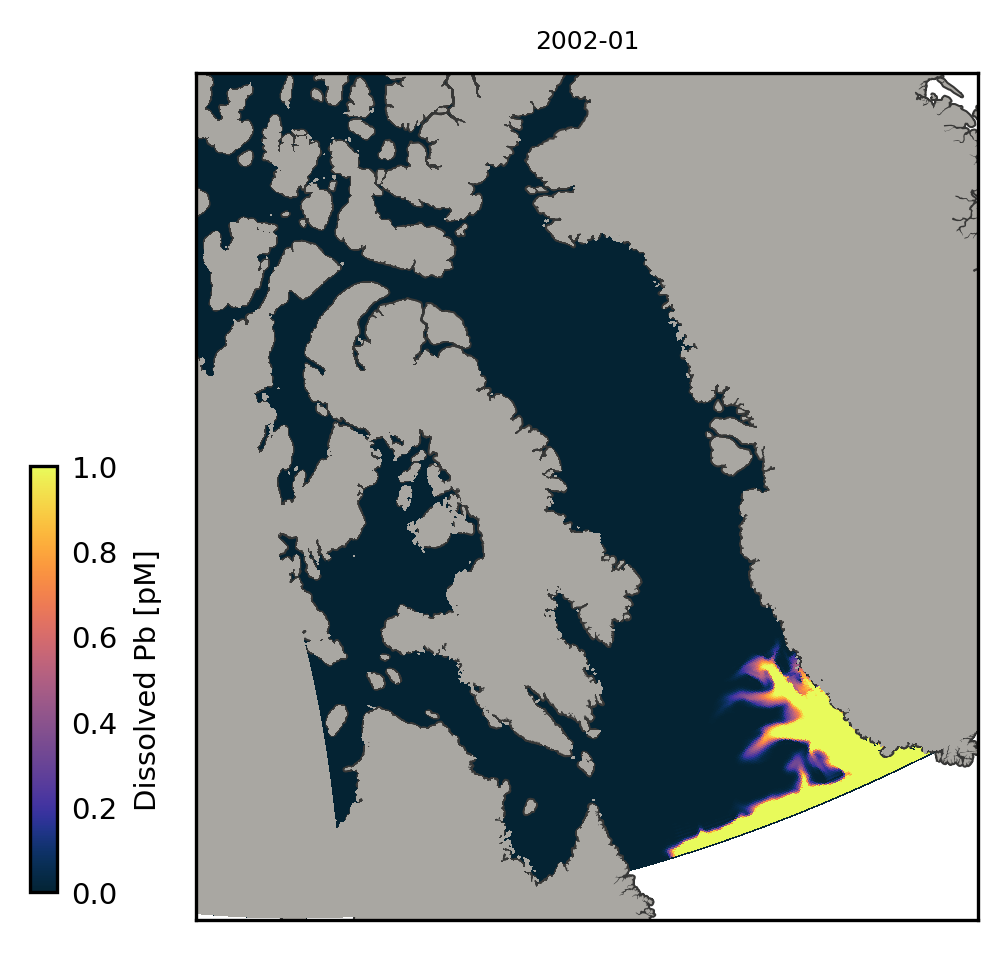

In [13]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/LS.pickle','rb'))
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 

anim = animation.FuncAnimation(fig, animate, 12*len(years), interval=1000, repeat = False)

# Color bar: --------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.10, 0.15, 0.02, 0.38]);
CBar   = plt.colorbar(CB, cax=cbaxes); 
CBar.set_label('Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

In [14]:
file = r'/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/Labrador-Sea-tracer.mp4'
anim.save(f'{file}', fps=1)

In [ ]:
with open(f,'rb') as anim:
     display(Image(anim.read()))